# Plots for Capsule Compression
In this notebook we conduct calculations for the force curves of various compressed droplets. The theory is summarised in Capsule_Compression_Summary.pdf

In [1]:
#Call Relevant Packages
using Optim
using DifferentialEquations
using Plots
using QuadGK
using LaTeXStrings

#Define Function for Calculating the Profile of the Compressed Droplet as a function
#of the contact angle, θ, and the degree of compression, δ. All variables are non-dimensional
function Compressed_Capsule_Solution(δ, θ)

    #Define Objective Function to be Minimised
    function Objective_f(z)
        #Extract out variables from z
        y0 = z[1]; λ = z[2]

        #Define ODE Problem
        f(u,p,t) = [u[2]; (1+u[2]^2)/u[1] + 2λ*(1+u[2]^2)^(3/2)]
        u0 = [y0; 0.0]
        tspan = (0.0,δ)
        prob = ODEProblem(f,u0,tspan)
        sol = solve(prob,Tsit5(),reltol=1e-8,abstol=1e-8,verbose=false)
        xmax = sol.t[end]

        #Determine whether or not solution reached x = δ
        Solver_reached_δ = xmax >= δ

        #Return value of objective
        if Solver_reached_δ
            integral, err = quadgk( x -> sol(x)[1]^2, 0, δ)
            return (2/3 - integral)^2 + (sol(δ)[2]/cot(θ) - 1)^2
        else
            return (cot(θ))^2*(100*(δ - xmax) + 1)
        end
    end

    #Define Function for calculating the areas of the surfaces on the compressed capsule
    function Area_normalised(y0, λ)

        #Define ODE Problem
        f(u,p,t) = [u[2]; (1+u[2]^2)/u[1] + 2λ*(1+u[2]^2)^(3/2)]
        u0 = [y0; 0.0]
        tspan = (0.0,δ)
        prob = ODEProblem(f,u0,tspan)
        sol = solve(prob,Tsit5(),reltol=1e-8,abstol=1e-8,verbose=false)
        A_dl, err = quadgk( x -> sol(x)[1]*sqrt(1+sol(x)[2]^2), 0, δ)
        A_ds = sol(δ)[1]^2/2
        return [A_dl, A_ds]
    end

    #Find Solution to Eigenvalue Problem Using Nelder-Mead Algorithm
    results = optimize(Objective_f,[1.01, -1.0], NelderMead(), Optim.Options(g_tol = 1e-20,iterations=5000))
    (y0, λ) = results.minimizer              #Calculated value of eigenvalue, λ, and y(x=0)
    (A_dl, A_ds) = Area_normalised(y0, λ)    #Calculate Area of Compressed Capsule
    minval = results.minimum
    iters = results.iterations
    
    #Solve ODE's one final time with correct values (for plotting purposes)
    f(u,p,t) = [u[2]; (1+u[2]^2)/u[1] + 2λ*(1+u[2]^2)^(3/2)]
    u0 = [y0; 0.0]
    tspan = (0.0,δ)
    prob = ODEProblem(f,u0,tspan)
    sol = solve(prob,Tsit5(),reltol=1e-8,abstol=1e-8,verbose=false)
    return [y0, λ, A_ds, A_dl, minval, iters, sol]
end

#Create function for simple model
function Area_Simple_Model(δ)
    y = -π*δ/4 + 1/2*sqrt(π^2*δ^2/4 - 8/3*δ^2 + 8/3*1/δ)
    A_ds = y^2/2
    A_dl = δ^2 + π*δ*y/2
    A = A_ds + A_dl
    return [y,A_dl,A_ds]
end

#Create Function to Evaluate Force Curve via Finite Differences
function Force_Curve(δ,θ)
    Δδ = min(1e-3, (1-δ)/2)
    sol_1 = Compressed_Capsule_Solution(δ-Δδ, θ)
    sol_2 = Compressed_Capsule_Solution(δ+Δδ, θ)
    A_dl_1 = sol_1[4]
    A_ds_1 = sol_1[3] 
    A_dl_2 = sol_2[4]
    A_ds_2 = sol_2[3] 
    return -((A_dl_2 - A_dl_1)/(2Δδ) - cos(θ)*(A_ds_2 - A_ds_1)/(2Δδ))
end

#Create Function to Evaluate Force Curve for Simple Model via Finite Differences
function Force_Curve_Simple(δ,θ)
    Δδ = min(1e-3, (1-δ)/2)
    sol_1 = Area_Simple_Model(δ-Δδ)
    sol_2 = Area_Simple_Model(δ+Δδ)
    A_dl_1 = sol_1[2]
    A_ds_1 = sol_1[3]
    A_dl_2 = sol_2[2]
    A_ds_2 = sol_2[3]
    return -((A_dl_2 - A_dl_1)/(2Δδ) - cos(θ)*(A_ds_2 - A_ds_1)/(2Δδ))
end


Force_Curve_Simple (generic function with 1 method)

## Plots
We now create plots of several force curves, and also compare them with the theoretical curve derived from a simple model created previously.

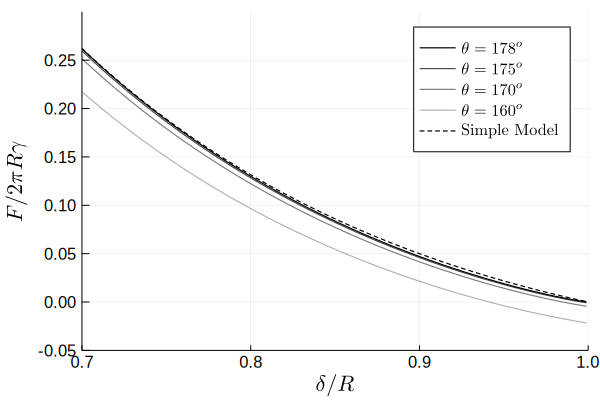

In [2]:
#Calculate Force Curves for Various Values of θ:
N = 50; δvals = LinRange(0.7,0.999,N); 
F_vals_2 = zeros(N); F_vals_5 = zeros(N); F_vals_10 = zeros(N); F_vals_20 = zeros(N);
F_vals_simp = zeros(N)
for i in 1:N
    F_vals_2[i] = Force_Curve(δvals[i],π-2*π/180)
    F_vals_5[i] = Force_Curve(δvals[i],π-5*π/180)
    F_vals_10[i] = Force_Curve(δvals[i],π-10*π/180)
    F_vals_20[i] = Force_Curve(δvals[i],π-20*π/180)
    F_vals_simp[i] = Force_Curve_Simple(δvals[i],π)
end

Plots.scalefontsizes()
Plots.scalefontsizes(1.4)
plot(δvals, F_vals_2, color= "black", lw = 1.2, label = L"\theta = 178^o", xlabel = L"\delta/R", ylabel = L"F/2\pi R\gamma", xlims = (0.7,1.0), ylims = (-0.05,0.3))
plot!(δvals, F_vals_5, color= "black", lw = 1.2, alpha=0.7, label = L"\theta = 175^o")
plot!(δvals, F_vals_10, color= "black",lw = 1.2, alpha=0.5, label = L"\theta = 170^o")
plot!(δvals, F_vals_20, color= "black",lw = 1.2, alpha=0.3, label = L"\theta = 160^o")
plot!(δvals, F_vals_simp, color= "black", lw = 1.2, linestyle = :dash,  label = L"\mathrm{Simple\ Model}")


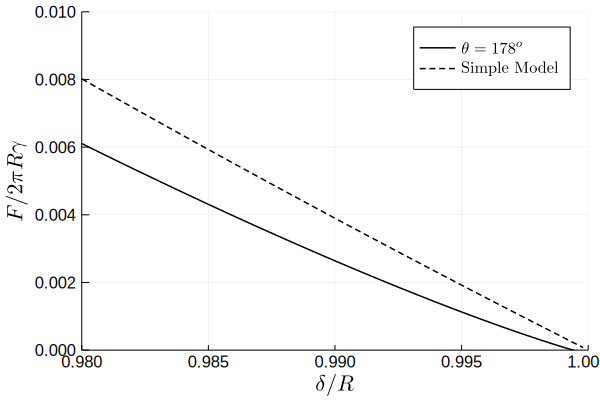

In [3]:
#Calculate Force Curves for Various Values of θ:
N = 50; δvals_close = LinRange(0.98,0.9998,N); 
F_vals_2_close = zeros(N); F_vals_simp_close = zeros(N)
for i in 1:N
    F_vals_2_close[i] = Force_Curve(δvals_close[i],π-2*π/180)
    F_vals_simp_close[i] = Force_Curve_Simple(δvals_close[i],π)
end

using LaTeXStrings
Plots.scalefontsizes()
Plots.scalefontsizes(1.4)
plot(δvals_close, F_vals_2_close, color= "black", lw=1.5, label = L"\theta = 178^o", xlabel = L"\delta/R", ylabel = L"F/2\pi R\gamma",xlims=(0.98,1.0), ylims = (0.0,0.01))
plot!(δvals_close, F_vals_simp_close, color= "black", lw=1.5, linestyle = :dash,  label = L"\mathrm{Simple\ Model}")


## Create Plots of Droplet Profiles
We now create plots of the squashed droplets, for various contact angles, $\theta$, and various degrees of compression, $\delta$.

### $\theta = 178^{\mathrm{o}}$

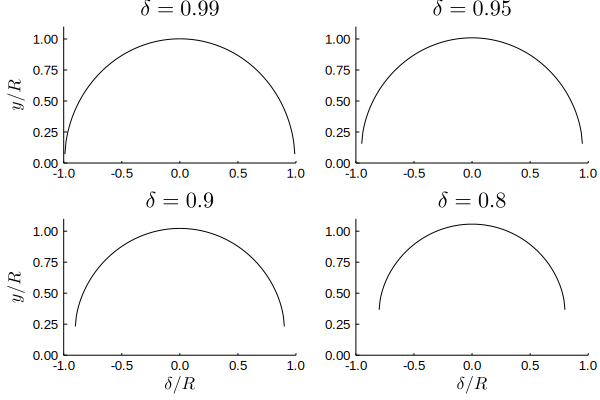

In [4]:
#Create Plot of Droplet Profiles for small θ value
Plots.scalefontsizes()
Plots.scalefontsizes(1.1)

θ = π - 2*pi/180

#Solve for case δ = 0.01
δ = 0.99
#Solve Eigenvalue Problem
sol = Compressed_Capsule_Solution(δ, θ)[7]
p1 = plot(LinRange(0,δ,100), t -> sol(t)[1], label = "", color="black", title = L"\delta=0.99", ylabel = L"y/R", grid=false, ylims = (0,1.1), xlims = (-1,1))
plot!(LinRange(-δ,0,100), t -> sol(-t)[1], label = "", color="black")

#Solve for case δ = 0.05
δ = 0.95
#Solve Eigenvalue Problem
sol = Compressed_Capsule_Solution(δ, θ)[7]
p2 = plot(LinRange(0,δ,100), t -> sol(t)[1], label = "", color="black", title = L"\delta=0.95",grid=false, ylims = (0,1.1), xlims = (-1,1))
plot!(LinRange(-δ,0,100), t -> sol(-t)[1], label = "", color="black")

#Solve for case δ = 0.1
δ = 0.9
#Solve Eigenvalue Problem
sol = Compressed_Capsule_Solution(δ, θ)[7]
p3 = plot(LinRange(0,δ,100), t -> sol(t)[1], label = "", color="black", title = L"\delta=0.9",ylabel = L"y/R", xlabel = L"\delta/R", grid=false,  ylims = (0,1.1), xlims = (-1,1))
plot!(LinRange(-δ,0,100), t -> sol(-t)[1], label = "", color="black")

#Solve for case δ = 0.2
δ = 0.8
#Solve Eigenvalue Problem
sol = Compressed_Capsule_Solution(δ, θ)[7]
p4 = plot(LinRange(0,δ,100), t -> sol(t)[1], label = "", color="black", title = L"\delta=0.8", xlabel = L"\delta/R", grid=false, ylims = (0,1.1), xlims = (-1,1))
plot!(LinRange(-δ,0,100), t -> sol(-t)[1], label = "", color="black")

#Combine Plots
l = @layout [a b ; c d]
plot(p1, p2, p3, p4, layout = l)

### $\theta = 175^{\mathrm{o}}$

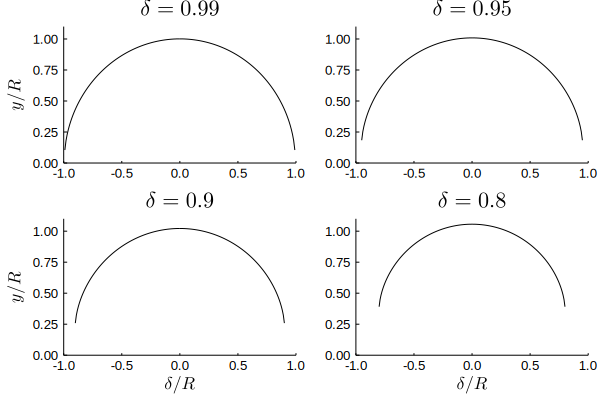

In [5]:
#Create Plot of Droplet Profiles for small θ value
Plots.scalefontsizes()
Plots.scalefontsizes(1.1)

θ = π - 5*pi/180

#Solve for case δ = 0.01
δ = 0.99
#Solve Eigenvalue Problem
sol = Compressed_Capsule_Solution(δ, θ)[7]
p1 = plot(LinRange(0,δ,100), t -> sol(t)[1], label = "", color="black", title = L"\delta=0.99", ylabel = L"y/R", grid=false, ylims = (0,1.1), xlims = (-1,1))
plot!(LinRange(-δ,0,100), t -> sol(-t)[1], label = "", color="black")

#Solve for case δ = 0.05
δ = 0.95
#Solve Eigenvalue Problem
sol = Compressed_Capsule_Solution(δ, θ)[7]
p2 = plot(LinRange(0,δ,100), t -> sol(t)[1], label = "", color="black", title = L"\delta=0.95",grid=false, ylims = (0,1.1), xlims = (-1,1))
plot!(LinRange(-δ,0,100), t -> sol(-t)[1], label = "", color="black")

#Solve for case δ = 0.1
δ = 0.9
#Solve Eigenvalue Problem
sol = Compressed_Capsule_Solution(δ, θ)[7]
p3 = plot(LinRange(0,δ,100), t -> sol(t)[1], label = "", color="black", title = L"\delta=0.9",ylabel = L"y/R", xlabel = L"\delta/R", grid=false,  ylims = (0,1.1), xlims = (-1,1))
plot!(LinRange(-δ,0,100), t -> sol(-t)[1], label = "", color="black")

#Solve for case δ = 0.2
δ = 0.8
#Solve Eigenvalue Problem
sol = Compressed_Capsule_Solution(δ, θ)[7]
p4 = plot(LinRange(0,δ,100), t -> sol(t)[1], label = "", color="black", title = L"\delta=0.8", xlabel = L"\delta/R", grid=false, ylims = (0,1.1), xlims = (-1,1))
plot!(LinRange(-δ,0,100), t -> sol(-t)[1], label = "", color="black")

#Combine Plots
l = @layout [a b ; c d]
plot(p1, p2, p3, p4, layout = l)

### $\theta = 170^{\mathrm{o}}$

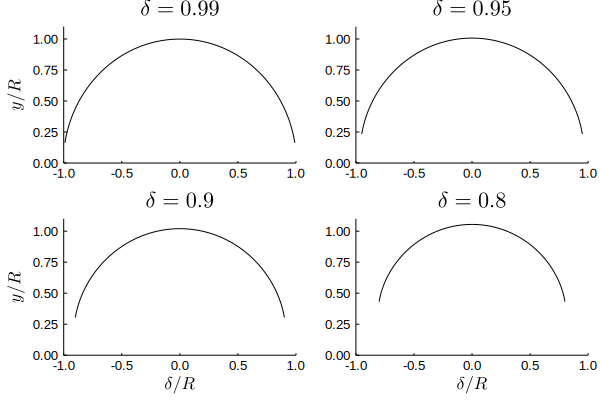

In [6]:
#Create Plot of Droplet Profiles for small θ value
Plots.scalefontsizes()
Plots.scalefontsizes(1.1)

θ = π - 10*pi/180

#Solve for case δ = 0.01
δ = 0.99
#Solve Eigenvalue Problem
sol = Compressed_Capsule_Solution(δ, θ)[7]
p1 = plot(LinRange(0,δ,100), t -> sol(t)[1], label = "", color="black", title = L"\delta=0.99", ylabel = L"y/R", grid=false, ylims = (0,1.1), xlims = (-1,1))
plot!(LinRange(-δ,0,100), t -> sol(-t)[1], label = "", color="black")

#Solve for case δ = 0.05
δ = 0.95
#Solve Eigenvalue Problem
sol = Compressed_Capsule_Solution(δ, θ)[7]
p2 = plot(LinRange(0,δ,100), t -> sol(t)[1], label = "", color="black", title = L"\delta=0.95",grid=false, ylims = (0,1.1), xlims = (-1,1))
plot!(LinRange(-δ,0,100), t -> sol(-t)[1], label = "", color="black")

#Solve for case δ = 0.1
δ = 0.9
#Solve Eigenvalue Problem
sol = Compressed_Capsule_Solution(δ, θ)[7]
p3 = plot(LinRange(0,δ,100), t -> sol(t)[1], label = "", color="black", title = L"\delta=0.9",ylabel = L"y/R", xlabel = L"\delta/R", grid=false,  ylims = (0,1.1), xlims = (-1,1))
plot!(LinRange(-δ,0,100), t -> sol(-t)[1], label = "", color="black")

#Solve for case δ = 0.2
δ = 0.8
#Solve Eigenvalue Problem
sol = Compressed_Capsule_Solution(δ, θ)[7]
p4 = plot(LinRange(0,δ,100), t -> sol(t)[1], label = "", color="black", title = L"\delta=0.8", xlabel = L"\delta/R", grid=false, ylims = (0,1.1), xlims = (-1,1))
plot!(LinRange(-δ,0,100), t -> sol(-t)[1], label = "", color="black")

#Combine Plots
l = @layout [a b ; c d]
plot(p1, p2, p3, p4, layout = l)

### $\theta = 160^{\mathrm{o}}$

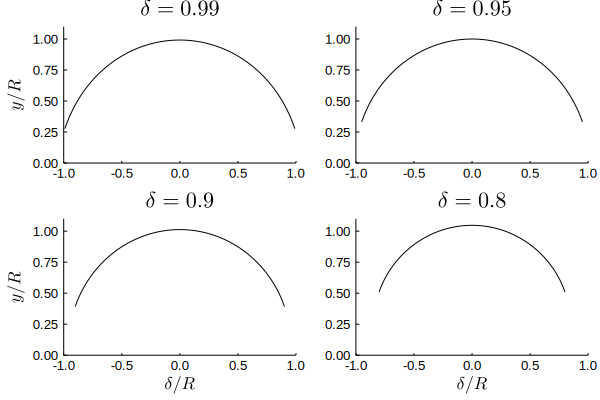

In [7]:
#Create Plot of Droplet Profiles for small θ value
Plots.scalefontsizes()
Plots.scalefontsizes(1.1)

θ = π - 20*pi/180

#Solve for case δ = 0.01
δ = 0.99
#Solve Eigenvalue Problem
sol = Compressed_Capsule_Solution(δ, θ)[7]
p1 = plot(LinRange(0,δ,100), t -> sol(t)[1], label = "", color="black", title = L"\delta=0.99", ylabel = L"y/R", grid=false, ylims = (0,1.1), xlims = (-1,1))
plot!(LinRange(-δ,0,100), t -> sol(-t)[1], label = "", color="black")

#Solve for case δ = 0.05
δ = 0.95
#Solve Eigenvalue Problem
sol = Compressed_Capsule_Solution(δ, θ)[7]
p2 = plot(LinRange(0,δ,100), t -> sol(t)[1], label = "", color="black", title = L"\delta=0.95",grid=false, ylims = (0,1.1), xlims = (-1,1))
plot!(LinRange(-δ,0,100), t -> sol(-t)[1], label = "", color="black")

#Solve for case δ = 0.1
δ = 0.9
#Solve Eigenvalue Problem
sol = Compressed_Capsule_Solution(δ, θ)[7]
p3 = plot(LinRange(0,δ,100), t -> sol(t)[1], label = "", color="black", title = L"\delta=0.9",ylabel = L"y/R", xlabel = L"\delta/R", grid=false,  ylims = (0,1.1), xlims = (-1,1))
plot!(LinRange(-δ,0,100), t -> sol(-t)[1], label = "", color="black")

#Solve for case δ = 0.2
δ = 0.8
#Solve Eigenvalue Problem
sol = Compressed_Capsule_Solution(δ, θ)[7]
p4 = plot(LinRange(0,δ,100), t -> sol(t)[1], label = "", color="black", title = L"\delta=0.8", xlabel = L"\delta/R", grid=false, ylims = (0,1.1), xlims = (-1,1))
plot!(LinRange(-δ,0,100), t -> sol(-t)[1], label = "", color="black")

#Combine Plots
l = @layout [a b ; c d]
plot(p1, p2, p3, p4, layout = l)